In [1]:
import pandas as pd
from glob import glob
import numpy as np
pd.set_option('display.max_rows', 300) 
data = "920"

## Data exploration

In [2]:
vertices = pd.read_csv(f"../../preds{data}/strainselect/StrainSelect21_vertices.tab.txt",sep="\t")

/scratch/slurm_tmpdir/job_23842754/ipykernel_636467/1949464331.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vertices = pd.read_csv(f"../../preds{data}/strainselect/StrainSelect21_vertices.tab.txt",sep="\t")


In [3]:
vertices

,vertex,vertex_type,StrainSelectID,StrainSelectID_2019
0,103nt4.lake.natron,gss,t__595640,NaN
1,X92163,contig,t__595640,NaN
2,g16_0915863,g16,t__595640,NaN
3,105nt4.lake.natron,gss,t__575259,NaN
4,X92166,contig,t__575259,NaN
...,...,...,...,...
4002304,g16_0917076,g16,t__364615,NaN
4002305,leptospira.biflexa.mutant.2.1993,gss,t__364615,NaN
4002306,Z98593,contig,t__387752,NaN
4002307,g16_0917077,g16,t__387752,NaN


In [4]:
vertices.vertex_type.value_counts()

vertex_type
g16               884828
gss               878311
contig            720657
gb_assembly       275232
rs_assembly       259195
wgs_master_pre    245975
patric_genome     234506
gold_org          195479
si_culture_id     142317
brc_cat_id        117202
si_grouping_id     24298
biocyc_pgdb        17505
kegg_genome         6794
sg_assembly           10
Name: count, dtype: int64

In [5]:
df = pd.read_parquet(f"../../preds{data}/REL_output/preds_strainselect.pqt")

In [6]:
df.StrainSelectID.unique().shape

(57054,)

In [7]:
df.rel.value_counts()

rel
STRAIN-COMPOUND:PRODUCES          650292
STRAIN-MEDIUM:GROWS_ON            439790
STRAIN-EFFECT:PRESENTS            409478
STRAIN-PHENOTYPE:PRESENTS         381425
STRAIN-ORGANISM:INFECTS           331281
STRAIN-EFFECT:PROMOTES            280759
STRAIN-ISOLATE:INHABITS           274341
STRAIN-ORGANISM:INHABITS          188424
STRAIN-COMPOUND:RESISTS           178491
STRAIN-DISEASE:ASSOCIATED_WITH     93609
COMPOUND-STRAIN:INHIBITS           82990
STRAIN-SPECIES:INHIBITS            68973
STRAIN-COMPOUND:DEGRADES           57354
STRAIN-DISEASE:INHIBITS            26697
STRAIN-ORGANISM:SYMBIONT_OF        17703
STRAIN-ORGANISM:INHIBITS           16356
STRAIN-EFFECT:INHIBITS              6418
Name: count, dtype: int64

In [8]:
df.vertex_type.value_counts()

vertex_type
gss               809193
brc_cat_id         10869
contig             10137
wgs_master_pre      2638
biocyc_pgdb         1383
si_culture_id       1055
g16                  613
si_grouping_id       164
Name: count, dtype: int64

In [9]:
set(vertices.vertex_type.value_counts().index).difference(set(df.vertex_type.value_counts().index))

{'gb_assembly',
 'gold_org',
 'kegg_genome',
 'patric_genome',
 'rs_assembly',
 'sg_assembly'}

In [10]:
res=["STRAIN-SPECIES:INHIBITS","STRAIN-ORGANISM:INHIBIT",
     "STRAIN-ORGANISM:SYMBIONT_OF","STRAIN-ORGANISM:INFECTS",
    "STRAIN-DISEASE:ASSOCIATED_WITH"]

In [11]:
for re in res:
    df[df.rel==re].sort_values("word_qc").to_csv(f"network_files/{re}.csv")

<Axes: ylabel='Frequency'>

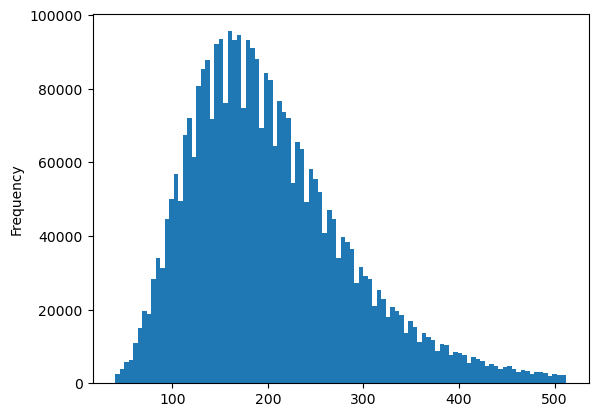

In [12]:
df.text.str.len().plot.hist(bins=100)

## Filter for existing assemblies and make network

In [13]:
folders = glob(f"../../assemblies_{data}/*")

In [14]:
strains = [f.split("/")[-1] for f in folders]

In [15]:
filtered_df= df[df.StrainSelectID.isin(strains)]

In [16]:
filtered_df.rel.value_counts()

rel
STRAIN-MEDIUM:GROWS_ON            117264
STRAIN-COMPOUND:PRODUCES           98566
STRAIN-PHENOTYPE:PRESENTS          95093
STRAIN-EFFECT:PRESENTS             58488
STRAIN-ISOLATE:INHABITS            52296
STRAIN-ORGANISM:INFECTS            49312
STRAIN-EFFECT:PROMOTES             34053
STRAIN-COMPOUND:RESISTS            32581
STRAIN-ORGANISM:INHABITS           20810
COMPOUND-STRAIN:INHIBITS           14790
STRAIN-COMPOUND:DEGRADES           11322
STRAIN-DISEASE:ASSOCIATED_WITH      8974
STRAIN-SPECIES:INHIBITS             8957
STRAIN-DISEASE:INHIBITS             6426
STRAIN-ORGANISM:SYMBIONT_OF         4226
STRAIN-ORGANISM:INHIBITS            2033
STRAIN-EFFECT:INHIBITS              1007
Name: count, dtype: int64

### Make network for all strain select

In [19]:
network = df[df.StrainSelectID.isna() == False].loc[:,["StrainSelectID","word_qc","rel"]].drop_duplicates(["StrainSelectID","word_qc","rel"])
network.loc[:,"source"] = np.where(network['rel'].str.startswith("STRAIN"), network.StrainSelectID	, network.word_qc)
network.loc[:,"target"] = np.where(network['rel'].str.startswith("STRAIN")==False, network.StrainSelectID, network.word_qc)

network = network.loc[:,["source","target","rel"]]

network = pd.concat([network,
    network.rel.str.split(":",expand=True)[0].str.split("-",expand=True).rename(
    columns={0:"source_ner",1:"target_ner"})]
          ,axis=1
         )

network["rel"] = network.rel.str.split(":",expand=True)[1]

network.to_csv("network_files/network.tsv",index=False,sep="\t")

with open("network_files/strains.txt", "w") as f:
	for s in sorted(set(df[df.StrainSelectID.isna() == False].StrainSelectID.to_list())):
		f.write(f"{s}\n")

### Make network filtered

In [20]:
network = filtered_df.loc[:,["StrainSelectID","word_qc","rel"]].drop_duplicates(["StrainSelectID","word_qc","rel"])
network.loc[:,"source"] = np.where(network['rel'].str.startswith("STRAIN"), network.StrainSelectID	, network.word_qc)
network.loc[:,"target"] = np.where(network['rel'].str.startswith("STRAIN")==False, network.StrainSelectID, network.word_qc)

In [21]:
network = network.loc[:,["source","target","rel"]]

In [22]:
network = pd.concat([network,
    network.rel.str.split(":",expand=True)[0].str.split("-",expand=True).rename(
    columns={0:"source_ner",1:"target_ner"})]
          ,axis=1
         )

In [23]:
network["rel"] = network.rel.str.split(":",expand=True)[1]

In [24]:
network.to_csv("network_files/network_assemblies.tsv",index=False,sep="\t")

In [25]:
with open("network_files/strains_assemblies.txt", "w") as f:
	for s in sorted(set(filtered_df.StrainSelectID.to_list())):
		f.write(f"{s}\n")

## Get sample sentences

In [19]:
df_nonan = df.dropna(subset = "StrainSelectID")

In [20]:
words = ["gram","non","negative","positive","2","forming","-","promotion","degradation","expression","formation","macrophages","animals","p","s","r","f","c","b",".","e"]
l = []
for i in words:
	l.append(df_nonan[df_nonan["word_qc"]==i].sample(1).text.to_list())

with open("network_files/rel_to_reannotate.txt","w") as f:
	for s in [i for j in l for i in j]:
		f.write(f"{s}\n")